# Predictive analysis with k-nearest neighbors algorithm

I will be using a dataset provided with “The Elements of Statistical Learning: Data Mining, Inference, and Prediction” by Trevor Hastie, Robert Tibshirani & Jerome Friedman. 

> Normalized handwritten digits, automatically scanned from envelopes by the U.S. Postal Service. The original scanned digits are binary and of different sizes and orientations; the images here have been deslanted and size normalized, resulting in 16 x 16 grayscale images (Le Cun et al., 1990).
> 
> The data are in two gzipped files, and each line consists of the digit id (0-9) followed by the 256 grayscale values.
> 
> There are 7291 training observations and 2007 test observations [...]
> 
> The test set is notoriously "difficult", and a 2.5% error rate is excellent. [...]

## Sources
- https://web.stanford.edu/~hastie/ElemStatLearn/datasets/zip.info.txt
- https://web.stanford.edu/~hastie/ElemStatLearn/datasets/zip.test.gz
- https://web.stanford.edu/~hastie/ElemStatLearn/datasets/zip.train.gz

## Theoretical background 

- [Nearest Neighbors Classification](http://scikit-learn.org/stable/modules/neighbors.html#classification)
- [sklearn.neighbors.KNeighborsClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
- [Digits Classification Exercise](http://scikit-learn.org/stable/auto_examples/exercises/plot_digits_classification_exercise.html)
--- 

## Libraries

In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier

---

## Functions

In [3]:
"""
To calculate descriptive values for every character all values for a character 
need to be extracted from the dataset respectively. 
For style guidelines see 
https://www.python.org/dev/peps/pep-0008/#function-and-variable-names
"""
def get_data_for_character (data, character):
    # gets all columns in the first row with a matching character 
    data_for_character = pd.DataFrame(data[data[0] == character]) 
    # ignore the value in the first column and return only grayvalues 
    grayvalues = data_for_character.iloc[:,1:]
    return grayvalues

def make_character_image(data, character, aggregation):
    # calls the function get_data_for_character
    image_data = get_data_for_character(data, character)
    # calculate descriptive statistical values ("stats")
    if(aggregation == 'mean'):
        character_stats = pd.DataFrame(image_data.mean())
    elif(aggregation == 'median'):
        character_stats = pd.DataFrame(image_data.median())
    elif(aggregation == 'min'):
        character_stats = pd.DataFrame(image_data.min())
    elif(aggregation == 'max'):
        character_stats = pd.DataFrame(image_data.max())
    else:
        print("No valid aggregation method provided. Please select: mean, median, min, max.")
    # Reshape the output from 1*256 to 16*16 and return product 
    return character_stats.values.reshape(16,16)

In [4]:
"""
For handling of training and test datasets 
"""

class Experiment:
    def __init__(self, targets_train, targets_test):
        self.results_train = pd.DataFrame(targets_train, columns=["targets"])
        self.results_test = pd.DataFrame(targets_test, columns=["targets"])

        self.input_data = {}
        
        self.names = []        
        self.configs = []

        
    def get_names(self):
        return self.names
    
    
    def get_results(self):
        return self.results_train, self.results_test
    
    def get_config_map(self):
        for conf in self.configs:
            print("CONFIG:", conf['name'], conf['input_data_name'], \
                  "\tNo. of features:", self.input_data[conf['input_data_name']]['data'].shape[1])
    
    
    def add_input_data(self, name, data, description=""):
        self.input_data[name] = {'description': description, 'data': data}
    
    
    def add_config(self, algo, name, input_data_name):
        # TODO: add check for duplicate names
        if input_data_name not in self.input_data:
            print("ERROR: feature_set_name not found")
            return 
        
        self.names.append(name)
        self.configs.append({ 'name': name, 'algo': algo, 'input_data_name': input_data_name, 'fit': -1})
        

    def _fit(self, conf):
        # get features
        input_data = self.input_data[conf['input_data_name']]['data']

        # fit the features
        print("Fitting ", conf['name'], "... ",)
        
        start = time.time() # Start time 
        conf['fit'] = conf['algo'].fit(input_data, self.results_train['targets'])
        end = time.time() # End time
        
        print("done in ", end - start , "s.")

        
    
    def _test(self, conf, data, train):
        if data.shape[1] != self.input_data[conf['input_data_name']]['data'].shape[1]:
            print("ERROR: Number of input features does not match (", conf['name'], ")")
            return
        
        print("Testing data with", conf['name'], "... ",)
        
        start = time.time() # Start time 
        if train:
            self.results_train[conf['name']] = conf['algo'].predict(data)
        else:
            self.results_test[conf['name']] = conf['algo'].predict(data)
        end = time.time() # End time 
        
        print("done in ", end - start , "s.")

        
    def fit(self):
        '''Only trains algorithms if no fit has been calculated before'''
        for conf in self.configs:
            if conf['fit'] == -1:
                self._fit(conf)

                
    def fit_all(self, data):
        '''Trains all algorithms with given data'''
        for conf in self.configs:
            self._fit(conf)

            
    def refit(self, data):
        '''Retrains all algorithms with given data that have been trained before'''
        for conf in self.configs:
            if conf['fit'] != -1:
                self._fit(conf)

                
    def test(self, name, data, train=False):
        for conf in self.configs:
            if conf['fit'] != -1 and conf['name'] == name:
                self._test(conf, data, train)

    def test_all(self, data, train=False):
        for conf in self.configs:
            if conf['fit'] != -1:
                self._test(conf, data, train)

                
    def get_count_df(self, name):
        count_matrix = np.zeros((10,10)) 
        for digit in range(0,10):
            cluster_counts = self.results_train[self.results_train['targets'] == digit].groupby(name).count()['targets']
            for cluster in cluster_counts.keys():
                count_matrix[digit][cluster] = cluster_counts[cluster]
        
        col_names = []
        for i in range(0,10):
            col_names.append("C_" + str(i))
    
        return pd.DataFrame(count_matrix, columns=col_names)

    def get_norm_df(self, name):
        count_df = self.get_count_df(name)
        return count_df.divide(count_df.sum(1), axis=0)
    
    
    def get_all_error_rates(self):
        error_rates = {}
        for conf in self.configs:
            if (conf['fit'] != -1) & (conf['name'] in self.results_train.columns):
                error_rates[conf['name']] = self.get_error_rate(conf['name'])
        return error_rates
                
    def get_error_rate(self, name):
        '''Determine classification error by identifying best fitting column assignment'''

---

## Importing and preparing the data

In [5]:
# Read CSV file into a pandas DataFrame 
# Does *not* use first line as a header, recognizes white space character as a field separator 
# see https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html 
train_data = pd.read_csv("data/zip.train", header=None, sep=" ")
test_data = pd.read_csv("data/zip.test", header=None, sep=" ")

In [6]:
# Display the first lines of data to get a first impression 
train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,248,249,250,251,252,253,254,255,256,257
0,6.0,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000,-1.000,-0.631,0.862,...,0.823,1.000,0.482,-0.474,-0.991,-1.000,-1.000,-1.000,-1.0,NaN
1,5.0,-1.0,-1.0,-1.0,-0.813,-0.671,-0.809,-0.887,-0.671,-0.853,...,-0.671,-0.033,0.761,0.762,0.126,-0.095,-0.671,-0.828,-1.0,NaN
2,4.0,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,...,-1.000,-1.000,-0.109,1.000,-0.179,-1.000,-1.000,-1.000,-1.0,NaN
3,7.0,-1.0,-1.0,-1.0,-1.000,-1.000,-0.273,0.684,0.960,0.450,...,1.000,0.536,-0.987,-1.000,-1.000,-1.000,-1.000,-1.000,-1.0,NaN
4,3.0,-1.0,-1.0,-1.0,-1.000,-1.000,-0.928,-0.204,0.751,0.466,...,0.639,1.000,1.000,0.791,0.439,-0.199,-0.883,-1.000,-1.0,NaN


In [7]:
# Display the first lines of data to get a first impression 
test_data.head()

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
0,9,-1.0,-1.0,-1.0,-1.000,-1.0,-0.948,-0.561,0.148,0.384,...,-1.000,-0.908,0.430,0.622,-0.973,-1.000,-1.0,-1.0,-1.0,-1.0
1,6,-1.0,-1.0,-1.0,-1.000,-1.0,-1.000,-1.000,-1.000,-1.000,...,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0
2,3,-1.0,-1.0,-1.0,-0.593,0.7,1.000,1.000,1.000,1.000,...,1.000,0.717,0.333,0.162,-0.393,-1.000,-1.0,-1.0,-1.0,-1.0
3,6,-1.0,-1.0,-1.0,-1.000,-1.0,-1.000,-1.000,-1.000,-1.000,...,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0
4,6,-1.0,-1.0,-1.0,-1.000,-1.0,-1.000,-1.000,-0.858,-0.106,...,0.901,0.901,0.901,0.290,-0.369,-0.867,-1.0,-1.0,-1.0,-1.0


In [8]:
# Lose the last column of train dataset 
del train_data[257]

In [9]:
"""
The int() method can *not* be applied to a pandas Series, so in order to 
convert the values in row 0 to integers a lambda function is defined 
and applied on row 0 of the pandas Series. 
"""

int_x = lambda x: int(x)
train_data.iloc[:,0] = train_data.iloc[:,0].apply(int_x)

In [10]:
train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
0,6,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000,-1.000,-0.631,0.862,...,0.304,0.823,1.000,0.482,-0.474,-0.991,-1.000,-1.000,-1.000,-1.0
1,5,-1.0,-1.0,-1.0,-0.813,-0.671,-0.809,-0.887,-0.671,-0.853,...,-0.671,-0.671,-0.033,0.761,0.762,0.126,-0.095,-0.671,-0.828,-1.0
2,4,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,...,-1.000,-1.000,-1.000,-0.109,1.000,-0.179,-1.000,-1.000,-1.000,-1.0
3,7,-1.0,-1.0,-1.0,-1.000,-1.000,-0.273,0.684,0.960,0.450,...,-0.318,1.000,0.536,-0.987,-1.000,-1.000,-1.000,-1.000,-1.000,-1.0
4,3,-1.0,-1.0,-1.0,-1.000,-1.000,-0.928,-0.204,0.751,0.466,...,0.466,0.639,1.000,1.000,0.791,0.439,-0.199,-0.883,-1.000,-1.0


---

## Visualizing data

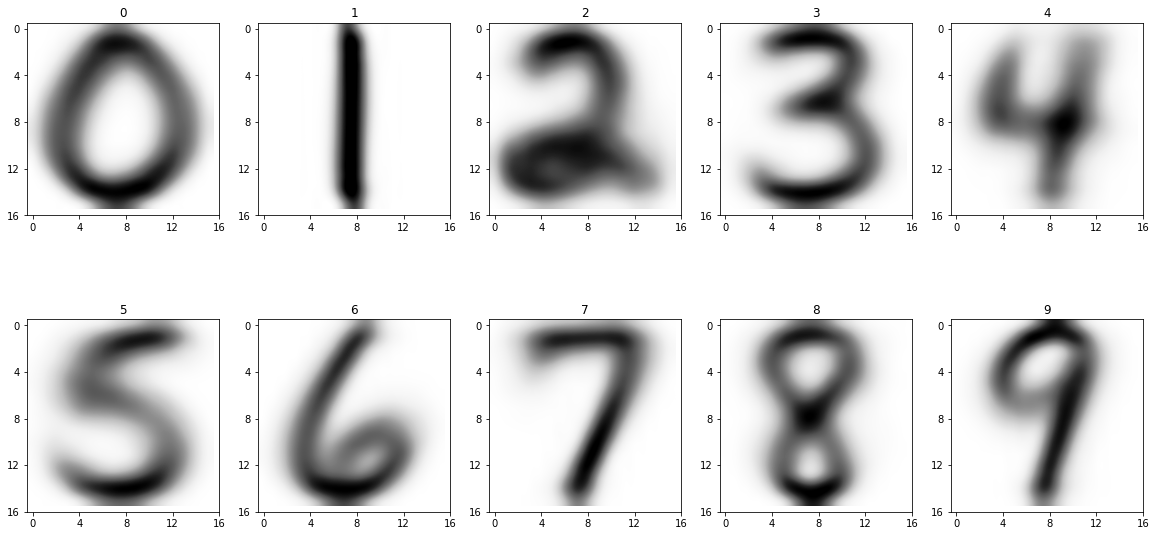

In [11]:
plt.figure(1, figsize=(20, 10))

for i in range(0,10):
    image = make_character_image(train_data,i,'mean')
    
    # create one subplot for every character 
    plt.subplot(2,5, 1 + i)
    plt.imshow(image, cmap='Greys', interpolation='Lanczos')
    ticks_val = [0, 4, 8, 12, 16] 
    ticks_lab = ['0', '4', '8', '12', '16'] 
    plt.title(i)
    plt.xticks(ticks_val, ticks_lab)
    plt.yticks(ticks_val, ticks_lab)
    
plt.show()

---

## Classification (Training)

In [12]:
input_data = train_data.iloc[:,1:].values
input_data.shape

(7291, 256)

In [13]:
# Set targets
exp = Experiment(train_data[0].values, test_data[0].values)

In [14]:
results_train, results_test = exp.get_results()

In [15]:
results_train.head()

,targets
0,6
1,5
2,4
3,7
4,3


### Add inputs

In [16]:
# input features are the individual pixels of the image - without transformation
exp.add_input_data('256_pixel', input_data)

In [17]:
exp.input_data

{'256_pixel': {'description': '',
  'data': array([[-1.   , -1.   , -1.   , ..., -1.   , -1.   , -1.   ],
         [-1.   , -1.   , -1.   , ..., -0.671, -0.828, -1.   ],
         [-1.   , -1.   , -1.   , ..., -1.   , -1.   , -1.   ],
         ...,
         [-1.   , -1.   , -1.   , ..., -1.   , -1.   , -1.   ],
         [-1.   , -1.   , -1.   , ..., -1.   , -1.   , -1.   ],
         [-1.   , -1.   , -1.   , ..., -1.   , -1.   , -1.   ]])}}

In [18]:
for n in range (3,6):
    exp.add_config(KNeighborsClassifier(n_neighbors=n, weights='uniform', n_jobs=-1), \
                   'KNN_' + str(n) + '_weight=uniform', '256_pixel')
    exp.add_config(KNeighborsClassifier(n_neighbors=n, weights='distance', n_jobs=-1), \
                   'KNN_' + str(n) + '_weight=distance', '256_pixel')

In [19]:
exp.get_names()

['KNN_3_weight=uniform',
 'KNN_3_weight=distance',
 'KNN_4_weight=uniform',
 'KNN_4_weight=distance',
 'KNN_5_weight=uniform',
 'KNN_5_weight=distance']

In [20]:
exp.get_config_map()

CONFIG: KNN_3_weight=uniform 256_pixel 	No. of features: 256
CONFIG: KNN_3_weight=distance 256_pixel 	No. of features: 256
CONFIG: KNN_4_weight=uniform 256_pixel 	No. of features: 256
CONFIG: KNN_4_weight=distance 256_pixel 	No. of features: 256
CONFIG: KNN_5_weight=uniform 256_pixel 	No. of features: 256
CONFIG: KNN_5_weight=distance 256_pixel 	No. of features: 256


In [21]:
exp.fit()

Fitting  KNN_3_weight=uniform ... 
done in  0.38976097106933594 s.
Fitting  KNN_3_weight=distance ... 
done in  0.3690958023071289 s.
Fitting  KNN_4_weight=uniform ... 
done in  0.37052488327026367 s.
Fitting  KNN_4_weight=distance ... 
done in  0.371140718460083 s.
Fitting  KNN_5_weight=uniform ... 
done in  0.3815345764160156 s.
Fitting  KNN_5_weight=distance ... 
done in  0.3903353214263916 s.


In [22]:
exp.test_all(input_data, train=True)

Testing data with KNN_3_weight=uniform ... 
done in  12.954318761825562 s.
Testing data with KNN_3_weight=distance ... 
done in  12.449019193649292 s.
Testing data with KNN_4_weight=uniform ... 
done in  11.840736150741577 s.
Testing data with KNN_4_weight=distance ... 
done in  11.946686506271362 s.
Testing data with KNN_5_weight=uniform ... 
done in  12.257506132125854 s.
Testing data with KNN_5_weight=distance ... 
done in  12.765860080718994 s.


In [23]:
results_train, results_test = exp.get_results()
results_train.head()

,targets,KNN_3_weight=uniform,KNN_3_weight=distance,KNN_4_weight=uniform,KNN_4_weight=distance,KNN_5_weight=uniform,KNN_5_weight=distance
0,6,6,6,6,6,6,6
1,5,5,5,5,5,5,5
2,4,4,4,4,4,4,4
3,7,7,7,7,7,7,7
4,3,3,3,3,3,3,3


### Accuracy 

In [24]:
exp_names = exp.get_names()
for name in exp_names:
    print(str(name) + ": " + str(1.0*(results_train['targets'] == results_train[name]).sum()\
                                 /results_train['targets'].count()))

KNN_3_weight=uniform: 0.9866959264847072
KNN_3_weight=distance: 1.0
KNN_4_weight=uniform: 0.9806610890138527
KNN_4_weight=distance: 1.0
KNN_5_weight=uniform: 0.9791523796461391
KNN_5_weight=distance: 1.0


---

## Classification (Test)

In [25]:
input_data = test_data.iloc[:,1:].values
input_data.shape

(2007, 256)

### Add inputs

In [26]:
exp.test_all(input_data, train=False)

Testing data with KNN_3_weight=uniform ... 
done in  3.6367592811584473 s.
Testing data with KNN_3_weight=distance ... 
done in  3.7212612628936768 s.
Testing data with KNN_4_weight=uniform ... 
done in  3.925196886062622 s.
Testing data with KNN_4_weight=distance ... 
done in  3.3186755180358887 s.
Testing data with KNN_5_weight=uniform ... 
done in  3.423593759536743 s.
Testing data with KNN_5_weight=distance ... 
done in  3.4172887802124023 s.


In [27]:
results_train, results_test = exp.get_results()
results_test.head()

,targets,KNN_3_weight=uniform,KNN_3_weight=distance,KNN_4_weight=uniform,KNN_4_weight=distance,KNN_5_weight=uniform,KNN_5_weight=distance
0,9,9,9,9,9,9,9
1,6,6,6,6,6,6,6
2,3,3,3,3,3,3,3
3,6,6,6,0,6,6,6
4,6,6,6,6,6,6,6


### Accuracy 

In [28]:
exp_names = exp.get_names()
for name in exp_names:
    print(str(name) + ": " + str(1.0*(results_test['targets'] == results_test[name]).sum()\
                                 /results_test['targets'].count()))

KNN_3_weight=uniform: 0.9446935724962631
KNN_3_weight=distance: 0.9451918285999004
KNN_4_weight=uniform: 0.9431988041853513
KNN_4_weight=distance: 0.9471848530144494
KNN_5_weight=uniform: 0.9446935724962631
KNN_5_weight=distance: 0.9451918285999004


---